<p align="center">
  <img src="../img/manfing.png" title="img-principal">
</p>

# CONTEXTO DO PROBLEMA

A **Manfing** é uma empresa que ajuda industrias, varejistas e instituições financeiras a entenderem o comportamento e consumo de seus clientes, para que possam tomar ações mais assertivas. Com isso, os clientes Manfing passam a ter uma previsão de vendas e demanda alinhada a dados de mercado, podendo aumentar seu faturamento e fidelização dos clientes.

A plataforma da Manfing utiliza inteligencia artificial para:

- Reativar clientes.
- Entender o consumo e comportamento.
- Recomendar novos produtos.
- Pricing interno e de concorrentes.
- Encontrar potencial de recompra ou novos SKUs.
- Criar campanhas de WhatsApp para o público alvo.

# O PROBLEMA

Um dos clientes da Manfing possui uma grande quantidade de clientes e entrou em contato, com uma necessidade de entender melhor o comportamento de seus consumidores para direcionar melhor o marketing e entender qual o perfil das pessoas que compram o produto.

# ENTENDIMENTO DO PROBLEMA

**Motivação:**
- Entender o comportamento dos consumidores.

**Causa Raiz do Problema:**
- Diercionar melhor o Marketing.

**Potênciais métodos:**
- Clusterização, Análise de dados.

**Entrega da Solução:**
- Jupyter Notebook.

# PLANEJAMENTO

**Descrição de Dados**
- Entender os dados e verificar nulos.

**Estatistica Descritiva**
- Avaliar estatisticas de primeira ordem e identificar inconsistências.

**Feature Engineering**
- Derivar/criar novas features.

**Análise Exploratória de Dados**
- Realizar análise univariada/bivariada/multivarida para encontrar insights sobre comportamente de clientes.

**Analisar métricas financeiras**
- Realizar análise para encontrar insights sobre consumo financeiro dos clientes.

# 0.0 IMPORTS

In [69]:
# manipulation
import pandas as pd
import inflection
import re

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# math and statistic
import numpy as np
from scipy import stats

# others
import warnings

## 0.1 Funções Auxiliares

In [67]:
warnings.filterwarnings("ignore") # ignore warnings
palette = ['#5e9fa3', '#dcd1b4', '#fab87f', '#f87e7b', '#b05574'] # color

# função para ajustar cor dos graficos
def set_color(value_counts, value):
    
    color = []
    cont  = 0
    for v in value_counts:
        
        cont +=1
        if cont in value:
            color.append(palette[0]) 
        else:
            color.append(palette[1])
            
    return color


# função com a formula do metodo de cramer v para correlação de variaveis categoricas
def cramer_v(x, y):
    
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = stats.chi2_contingency(cm)[0]
    chi2_corr = max(0, chi2 - (k-1) * (r-1) / (n-1))
    
    kcorr = k - (k-1) **2 / (n-1)
    rcorr = r - (r-1) **2 / (n-1)
    
    return np.sqrt((chi2_corr / n) / (min(kcorr-1, rcorr-1)))


# função para aplicar o cramer v em todas as colunas categoricas
def show_matrix(col, data, output='list'):

    rows = []
    index = []
    columns = []

    for c in data.columns:

        result = cramer_v(x=data[str(col)], y=data[str(c)])

        rows.append(result)
        index.append(str(c))
        columns.append(str(col))
        
    if output == 'list':
        return rows
    
    elif output == 'dict':
        return pd.DataFrame(rows, index=index, columns=[str(col)])

## 0.2 Carregamento de Dados

In [2]:
# lendo dados
data = pd.read_excel('../data/DataSet_Test.xlsx')

# mostrando dados
data.head()

,BillNo,Itemname,Quantity,Date,Price,CustomerID,Country
0,536365,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


# 1.0 DESCRIÇÃO DE DADOS

## 1.1 Dimensão de Dados

In [3]:
rows = data.shape[0] # quantidade de linhas
col  = data.shape[1] # quantidade de colunas

# mostrando qtd. linhas e colunas
print('Qty. Columns:', col)
print('Qty. Rows:', rows)

Qty. Columns: 7
Qty. Rows: 522064


## 1.2 Renomeação de Colunas

In [4]:
# função para passar o nome das colunas para o padrão snakecase
snakecase = lambda x: inflection.underscore(x)

# colunas originais
old_columns = data.columns 

# passando para snakecase e substituindo nos dados originais
data.columns = list(map(snakecase, old_columns))

# mostrando novas colunas atuais
data.columns

Index(['bill_no', 'itemname', 'quantity', 'date', 'price', 'customer_id',
       'country'],
      dtype='object')

## 1.3 Tipo de Dados

In [5]:
# verificando se os tipos de dados estão corretos
data.dtypes

bill_no                object
itemname               object
quantity                int64
date           datetime64[ns]
price                 float64
customer_id           float64
country                object
dtype: object

## 1.4 Dados Faltantes

In [6]:
# verificando se há dados nulos/faltantes
data.isna().sum()

bill_no             0
itemname         1455
quantity            0
date                0
price               0
customer_id    134041
country             0
dtype: int64

## 1.5 Tratamento de Dados Faltantes

### 1.5.1 Customer ID

**AÇÃO:** Criar novos ID´s para os clientes que não possuem.

In [7]:
START = 1900 # incicio dos Customer ID´s para quem não tem

# código de compras unicos
df_buckup = pd.DataFrame(data['bill_no'].drop_duplicates())

# gerando codigos de 1900 até o tamanho de codigo de compras unicas
df_buckup['customer_id'] = np.arange(START, START+len(df_buckup), 1)

# Fazendo um merge com a referencia de compra
df1 = pd.merge(data, df_buckup, on='bill_no', how='left')

# coalesce
df1['customer_id'] = df1['customer_id_x'].combine_first(df1['customer_id_y'])

# drop colunas extras criadas
df1.drop(columns=['customer_id_x', 'customer_id_y'], inplace=True)

# verificando quantidade de nulos 
df1.isna().sum()

bill_no           0
itemname       1455
quantity          0
date              0
price             0
country           0
customer_id       0
dtype: int64

### 1.5.2 Item Name

**AÇÃO:** Há dois tipos de ações pensadas:

1. deletar a coluna. 
- <ins>Beneficios</ins>: Manter mais 1.455 linhas/dados de clientes para análise.
- <ins>Riscos</ins>:     Falta de insight sobre o perfil do que os clientes compram em cada país.

2. excluir as linhas nulas.
- <ins>Beneficios</ins>: Conseguir insight sobre o perfil do que os clientes compram em cada país.
- <ins>Riscos</ins>:     Perder 1.455 linhas/dados de clientes para análise.

**Escolha:** Manter a coluna sobre o produto e excluir as linhas nulas.

In [8]:
# excluindo dados dados nulos
data = df1.dropna().copy()
data.isna().sum()

bill_no        0
itemname       0
quantity       0
date           0
price          0
country        0
customer_id    0
dtype: int64

## 1.4 Mudança Tipo de Dados

In [9]:
# customer_id: float para int
data['customer_id'] = data['customer_id'].astype('int')

# bill_no: de str para int (aqui dá erro)
data['bill_no'] = data['bill_no'].astype('int')

ValueError: invalid literal for int() with base 10: 'A563185'

**NOTA:**

1. Há 3 códigos de compra A563185, A563186, A563187 com uma letra "A" no código, indicando ajuste de debito no item comprado e preço negativo.

**AÇÃO:**

2. Remover as 3 compras, pois não foram consideradas compras de fato.

# 2.0 ESTATISTICA DESCRITIVA

## 2.1 Variaveis Numéricas

In [10]:
data.describe().drop(columns='customer_id').T

,count,mean,std,min,25%,50%,75%,max
quantity,520609.0,10.145545,160.818639,-9600.00,1.00,3.00,10.00,80995.00
price,520609.0,3.837497,41.958621,-11062.06,1.25,2.08,4.13,13541.33


**ANÁLISE:** 

1. Há quantidade de produtos negativos (Pode ser devolução?)
2. Há preço de produtos negativos (Pode ser promoção?)

**AÇÃO:**

- Price: Os 3 casos de preços negativos serão removidos.
- Quantity: Os casos de quantidade negativas serão mantidas e consideradas como produtos devolvidos (devoluções).

## 2.2 Variaveis Categóricas

In [11]:
# filtrando variaveis categóricas
categorical = data.select_dtypes(include=['object'])

# contando dados unicos para cada variavel categorica
categorical.apply(lambda x: len(x.unique()))

bill_no     20208
itemname     4185
country        30
dtype: int64

**INSIGHT:** 

- A empresa obteve 20.208 compras unicas.
- A empresa tem 4.185 itens únicos.
- A empresa tem clientes de 30 países distintos.

## 2.3 Variaveis de Data

In [12]:
start = data['date'].min()
end   = data['date'].max()

print('Start Date:', start)
print('End Date  :', end)

Start Date: 2010-12-01 08:26:00
End Date  : 2011-12-09 12:50:00


**INSIGHT:** Há dados de 1 ano da empresa, começando em dezembro de 2010 e termiando em dezembro de 2011.

# 3.0 FILTRAGEM DE DADOS

## 3.1 bill_no

Filtrar/excluir as 3 compras com código contendo "A".

In [13]:
# indetifcando letras na compra
bill_no_with_letter = list(data['bill_no'].apply(lambda x: x if 'A' in str(x) else None).unique())

# index das linhas com a compra que possui letra
index_bill_no_with_letter = list(data[data['bill_no'].isin(bill_no_with_letter)].index)

# drop linhas com codigo de compra possuindo letras
data.drop(index=index_bill_no_with_letter, inplace=True)

# passando o tipo para int
data['bill_no'] = data['bill_no'].astype('int')

## 3.2 Quantity

Dividindo 2 dataframes entre compras e devoluções.

In [14]:
# devoluções
returns = data.loc[data['quantity'] < 0, :]

# compras
purchases = data.loc[data['quantity'] >= 0, :].copy()

## 3.3 Price

Filtrando preços maiores que 0.04 para os casos de compras.

In [15]:
# mantendo apenas compras com preços maiores que 0.04
purchases = purchases.loc[purchases['price'] > 0.04, :]

# 3.0 Feature Engineering

## 3.1 Levantamento de Hipóteses

H1. Os clientes que fazem mais compras ficam no Reino Unido.

H2. Os clientes que gastam mais ficam na Espanha.

H3. Os clientes que levam a maior quantidade de produtos no carrinho ficam no Jpaão.

H4. Os clientes que levam a maior quantidade de itens no carrinho ficam na Alemanha.

H5. Clientes do Reino Unido possuem o maior Ticket Médio.

H6. Produtos relacionados a postagem/Amazon possuem o maior Ticket Médio.

H7. Clientes da frança possuem a maior recencia de compra.

H8. Os clientes do Reino Unido compram os produtos mais caros.

## 3.2 Criação de Feature

In [16]:
# derivando feature de Ano
purchases['year'] = purchases['date'].dt.year   # dados de compras
returns['year'] = returns['date'].dt.year       # dados de devoluções

# derivando feature de Mês
purchases['month'] = purchases['date'].dt.month # dados de compras
returns['month'] = returns['date'].dt.month     # dados de devoluções

# derivando feature de Dia
purchases['day'] = purchases['date'].dt.day     # dados de compras
returns['day'] = returns['date'].dt.day         # dados de devoluções

# criando feature 'gross_revenue': quantidade de produtos x preço unitario
purchases['gross_revenue'] = purchases['quantity'] * purchases['price']

# ticket medio por país
avg_ticket_country = purchases[['country', 'gross_revenue']].groupby('country').mean().reset_index().rename(columns={'gross_revenue': 'avg_ticket'}).sort_values(by='avg_ticket', ascending=False)

# ticket medio por produto
avg_ticket_product = purchases[['itemname', 'gross_revenue']].groupby('itemname').mean().reset_index().rename(columns={'gross_revenue': 'avg_ticket'}).sort_values(by='avg_ticket', ascending=False)

# Recency - Last day purchase por país
df_recency = purchases[['country', 'date']].groupby('country').max().reset_index()
df_recency['recency_days'] = (df_recency['date'].max() - df_recency['date']).dt.days

# Recency - Last day purchase por produto
recency_product = purchases[['itemname', 'date']].groupby('itemname').max().reset_index()
recency_product['recency_days'] = (recency_product['date'].max() - recency_product['date']).dt.days

# 4.0 Análise Exploratória de Dados

## 4.1 Análise Univariada

### 4.1.1 Variaveis Numéricas - (Compras)

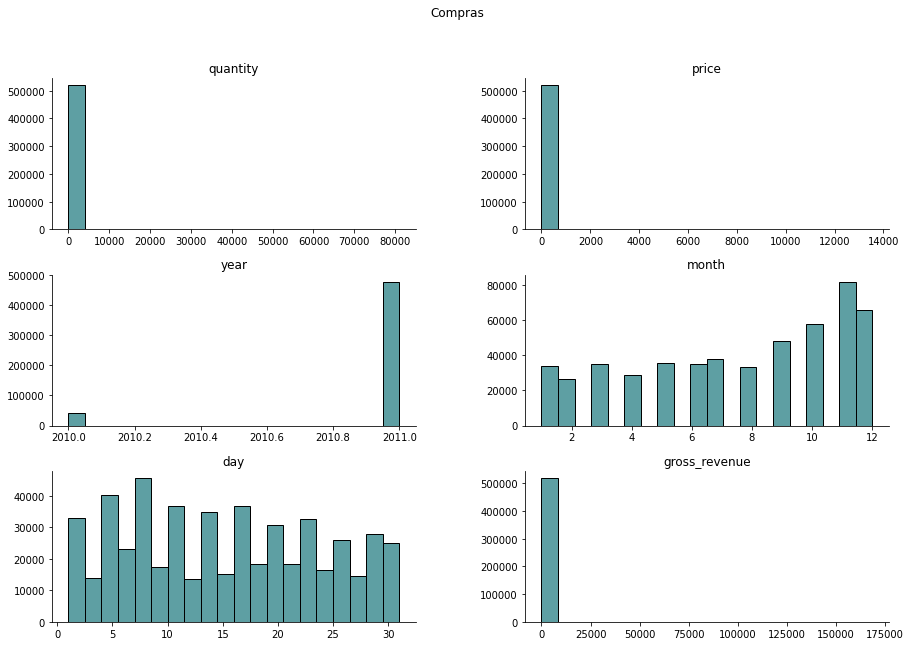

In [17]:
# plotando histograma de variaveis numéricas
purchases.drop(columns=['customer_id', 'date', 'bill_no']).hist(figsize=(15, 10), ec='k', bins=20, grid=False, color=palette[0])
sns.despine(right=True)
plt.suptitle('Compras');

**INSIGHT:**

- Quantity: A quantidade de itens em compras legítimas varia de 0 a 5.000. 
- Price: O preço dos produtos varia em torno de 0.04 a 1.300.
- Year: Há maior quantidade de compras em 2011.
- Month: No final do ano, há maior quantidade de compras.
- Day: Há maior quantidade de compras entre os dias 1 e 15.

### 4.1.2 Variaveis Numéricas - (Devoluções)

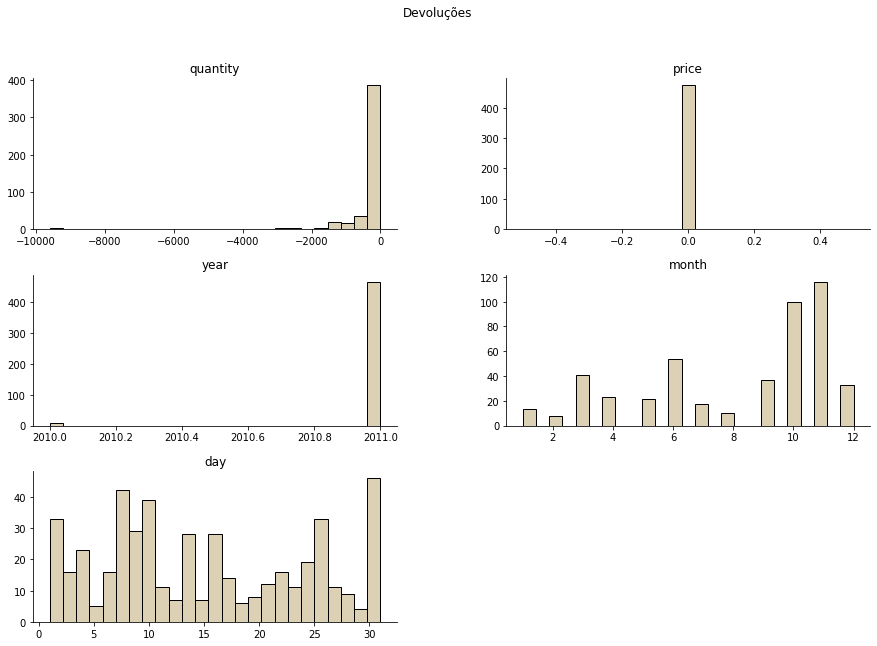

In [18]:
# plotando histograma de variaveis numéricas
returns.drop(columns=['customer_id', 'date', 'bill_no']).hist(figsize=(15, 10), ec='k', bins=25, grid=False, color=palette[1])
sns.despine(right=True)
plt.suptitle('Devoluções');

**INSIGHT:**

- Quantity: A maior parte da quanitdade de itens devolvidos está entre 1 e 2 mil itens.
- Price: As devoluções possuem valores zeradados.
- Day: A maior parte das devoluções aconteceram em 2011.
- Month: A maior parte das devoluções aconteceram nos meses 10 (outubro) e 11 (novembro).
- Day: A maior parte das devoluções aconteceram nos dias 30/31 e entre os dias 1 e 15.

### 4.1.3 Outliers - (Compras)

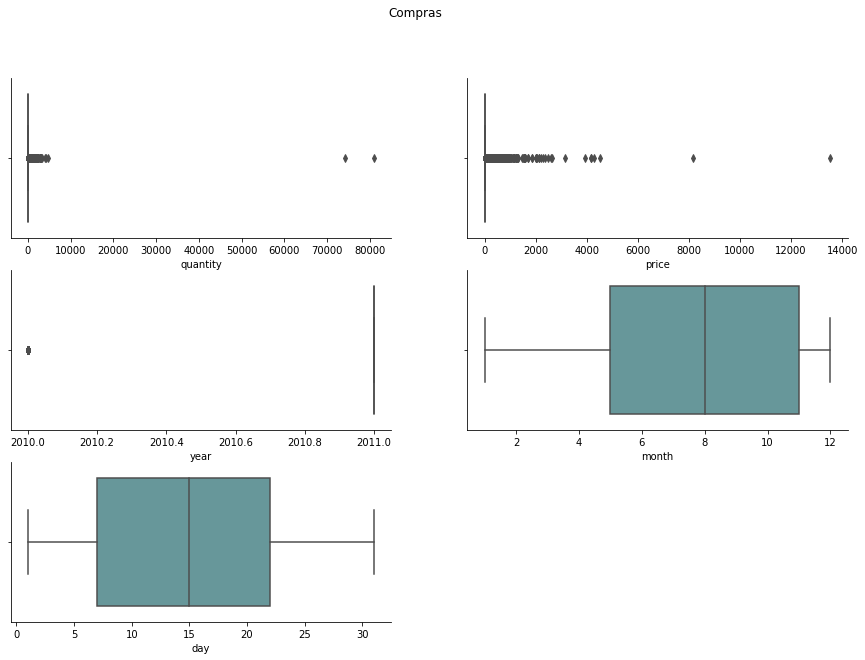

In [19]:
# 1º figura
plt.figure(figsize=(15, 10))
plt.subplot(3, 2, 1)
sns.boxplot(x='quantity', data=purchases, color=palette[0])

# 2º figura
plt.subplot(3, 2, 2)
sns.boxplot(x='price', data=purchases, color=palette[0])

# 3º figura
plt.subplot(3, 2, 3)
sns.boxplot(x='year', data=purchases, color=palette[0])

# 4º figura
plt.subplot(3, 2, 4)
sns.boxplot(x='month', data=purchases, color=palette[0])

# 5º figura
plt.subplot(3, 2, 5)
sns.boxplot(x='day', data=purchases, color=palette[0])
plt.suptitle('Compras')
sns.despine(right=True);

**INSIGHT:**

- Quantity: Há 2 compras com quantidade de itens acima do normal. Levando uma quantidade de itens acima de 70 mil.
- Price: Há 2 produtos com preços acima do normal. Custando mais que 8 mil.

#### 4.1.3.1 Investigando Outliers - (Compras)

#### 4.1.3.1.1 Quantity

Identificando os clientes e compras Outliers.

In [20]:
# filtrando compras com quantidade de itens maior que 70 mil
purchases[purchases['quantity'] > 70000]

,bill_no,itemname,quantity,date,price,country,customer_id,year,month,day,gross_revenue
59999,541431,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,United Kingdom,12346,2011,1,18,77183.6
520583,581483,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,United Kingdom,16446,2011,12,9,168469.6


Visualizando histórico de compra dos clientes Outliers.

In [21]:
# cliente 12346 não possui historico
# visualizando historico do cliente 16446
purchases[purchases['customer_id'] == 16446]

,bill_no,itemname,quantity,date,price,country,customer_id,year,month,day,gross_revenue
187655,553573,PANTRY SCRUBBING BRUSH,1,2011-05-18 09:52:00,1.65,United Kingdom,16446,2011,5,18,1.65
187656,553573,PANTRY PASTRY BRUSH,1,2011-05-18 09:52:00,1.25,United Kingdom,16446,2011,5,18,1.25
520583,581483,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,United Kingdom,16446,2011,12,9,168469.60


**ANÁLISE:**

Os 2 Outliers são o mesmo cliente que fez 2 compras em épocas diferentes. Em uma compra levou 74 mil itens de um produto no inicio de 2011, e, na outra, levou 80 mil itens de outro produto no final de 2011. O cliente com ID 12346, fez apenas uma compra. Já o cliente de ID 16446, fez 2 compras, na primeira, levou apenas 2 itens e na segunda, se tornou outlier levando 80 mil.

**AÇÃO:**

Excluir a compra do ID 16446 por parecer suspeita. Manter a compra do ID 12346, pois não parece ser um erro de sistema ou algo do tipo, aparenta ser alguém que revende produtos e quando tem uma promoção leva uma grande quantidade.

#### 4.1.3.1.2 Price

Identificando os produtos e compras Outliers.

In [22]:
# filtrando compras com preço do produto maior que 8 mil
purchases[purchases['price'] > 8000]

,bill_no,itemname,quantity,date,price,country,customer_id,year,month,day,gross_revenue
14696,537632,AMAZON FEE,1,2010-12-07 15:08:00,13541.33,United Kingdom,2543,2010,12,7,13541.33
167329,551697,POSTAGE,1,2011-05-03 13:46:00,8142.75,United Kingdom,16029,2011,5,3,8142.75


**ANÁLISE:**

Os 2 protudos com preços outliers são produtos "não convencionais", um é sobre postagem e outro é algum tipo de taxa da amazon. A análise feita é que a empresa oferece produtos deste tipo e que é vendido por "tamanho" do serviço, seja de postagem ou taxa algum produto envolvendo a Amazon.

**AÇÃO:**

Seguindo a premissa acima, será mantido as 2 compras.

### 4.1.4 Outliers - (Devoluções)

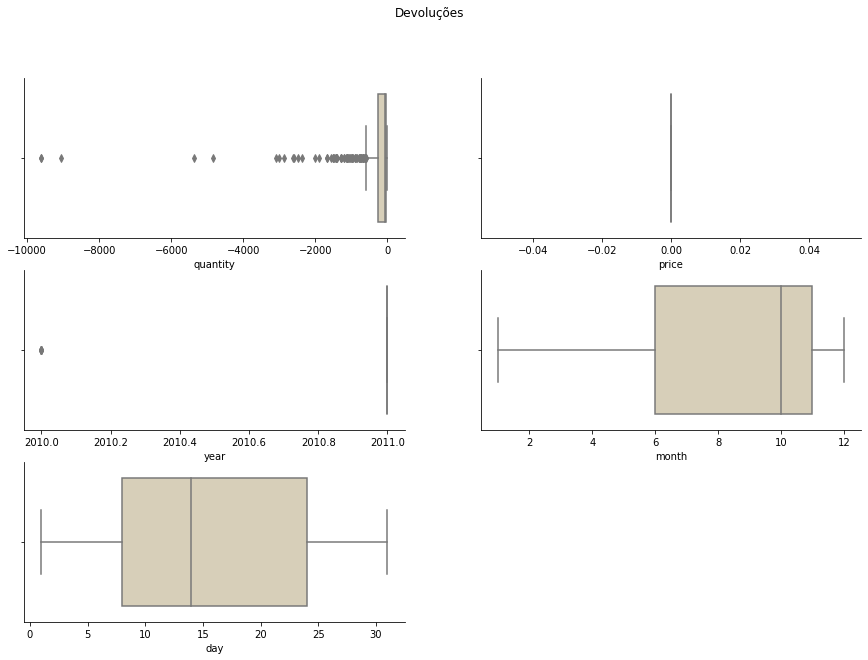

In [23]:
# 1º figura
plt.figure(figsize=(15, 10))
plt.subplot(3, 2, 1)
sns.boxplot(x='quantity', data=returns, color=palette[1])

# 2º figura
plt.subplot(3, 2, 2)
sns.boxplot(x='price', data=returns, color=palette[1])

# 3º figura
plt.subplot(3, 2, 3)
sns.boxplot(x='year', data=returns, color=palette[1])

# 4º figura
plt.subplot(3, 2, 4)
sns.boxplot(x='month', data=returns, color=palette[1])

# 5º figura
plt.subplot(3, 2, 5)
sns.boxplot(x='day', data=returns, color=palette[1])
plt.suptitle('Devoluções')
sns.despine(right=True);

**INSIGHT:**

- Quantity: Há 5 compras com quanitdade de itens devolvidos acima do normal. Devolvendo acima de 4 mil itens.

####  4.1.4.1 Investigando Outliers - (Devoluções)

#### 4.1.4.2 Quantity

Identificando clientes que devolveram mais de 4 mil itens.

In [24]:
returns[returns['quantity'] < -4000]

,bill_no,itemname,quantity,date,price,country,customer_id,year,month,day
111940,546152,throw away,-5368,2011-03-09 17:25:00,0.0,United Kingdom,6380,2011,3,9
217657,556687,Printing smudges/thrown away,-9058,2011-06-14 10:36:00,0.0,United Kingdom,11609,2011,6,14
217658,556690,printing smudges/thrown away,-9600,2011-06-14 10:37:00,0.0,United Kingdom,11610,2011,6,14
217659,556691,printing smudges/thrown away,-9600,2011-06-14 10:37:00,0.0,United Kingdom,11611,2011,6,14
414734,573596,"Unsaleable, destroyed.",-4830,2011-10-31 15:17:00,0.0,United Kingdom,19725,2011,10,31


**ANÁLISE:**

O comportamento das devoluções parecem ser normais, não demonstram ser erros de sistema ou algo do tipo. Todas as devoluções outliers aconteceram em 2011.

**AÇÃO:**

Manter as devoluções.

### 4.1.5 Variaveis Categóricas - (Compras)

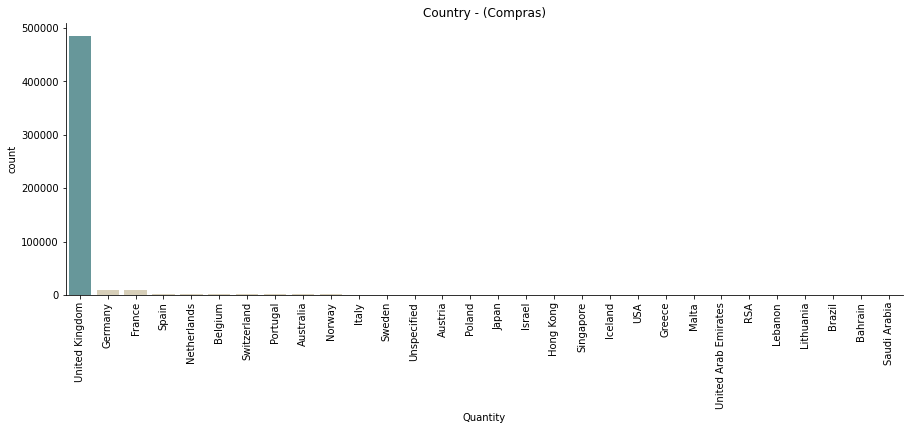

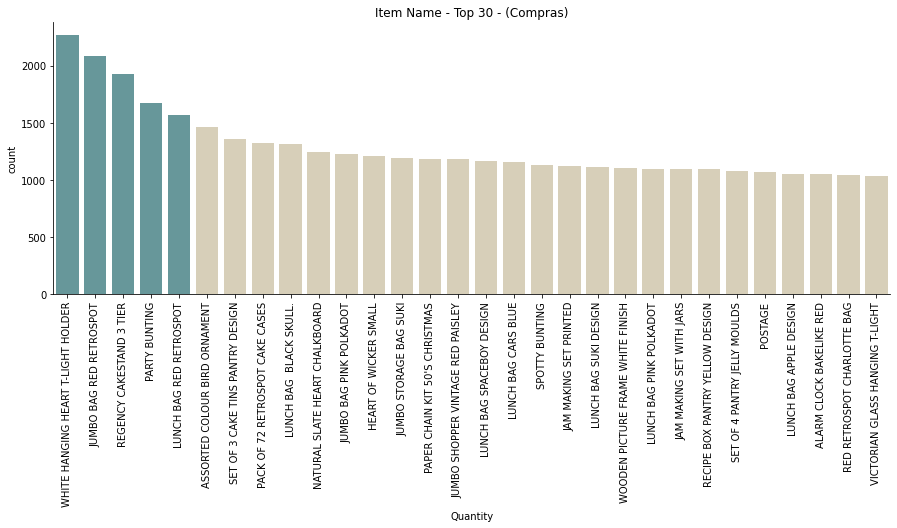

In [42]:
# figure 1
plt.figure(figsize=(15, 5))
order_country = purchases['country'].value_counts().sort_values(ascending=False)
color = set_color(order_country, [1]) # set color style
sns.countplot(x='country', data=purchases, order=order_country.index, palette=color)
sns.despine(right=True)
plt.xticks(rotation=90)
plt.xlabel('Quantity')
plt.title('Country - (Compras)');

# figure 2
plt.figure(figsize=(15, 5))
order_item = purchases['itemname'].value_counts().sort_values(ascending=False)[:30]
color = set_color(order_item, [1, 2, 3, 4, 5]) # set color style
sns.countplot(x='itemname', data=purchases, order=order_item.index, palette=color)
sns.despine(right=True)
plt.xticks(rotation=90)
plt.xlabel('Quantity')
plt.title('Item Name - Top 30 - (Compras)');

### 4.1.6 Variaveis Categóricas - (Devoluções)

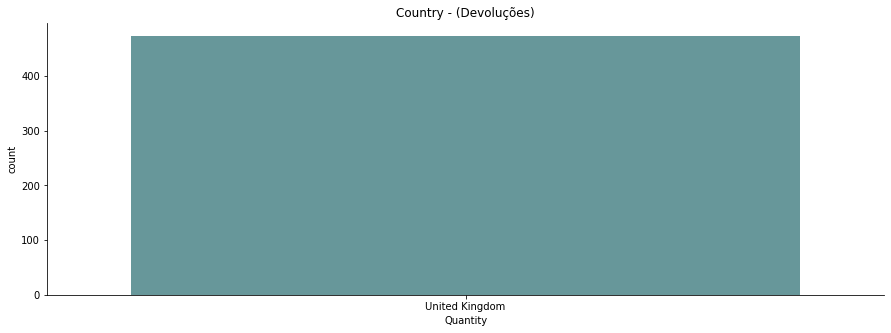

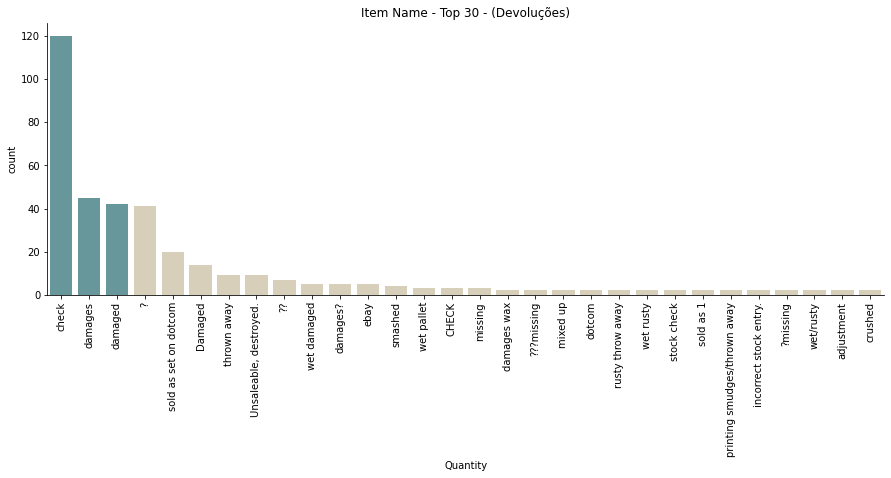

In [43]:
# figure 1
plt.figure(figsize=(15, 5))
order_country = returns['country'].value_counts().sort_values(ascending=False)
sns.countplot(x='country', data=returns, order=order_country.index, color=palette[0])
sns.despine(right=True)
plt.xlabel('Quantity')
plt.title('Country - (Devoluções)');

# figure 2
plt.figure(figsize=(15, 5))
order_item = returns['itemname'].value_counts().sort_values(ascending=False)[:30]
color = set_color(order_item, [1, 2, 3])
sns.countplot(x='itemname', data=returns, order=order_item.index, palette=color)
sns.despine(right=True)
plt.xticks(rotation=90)
plt.xlabel('Quantity')
plt.title('Item Name - Top 30 - (Devoluções)');

## 4.2 Análise Bivariada

### H1. Os clientes que fizeram mais compras ficam no Reino Unido.

**VERDADEIRA** Os clientes que fizeram mais compras ficam no Reino Unido.

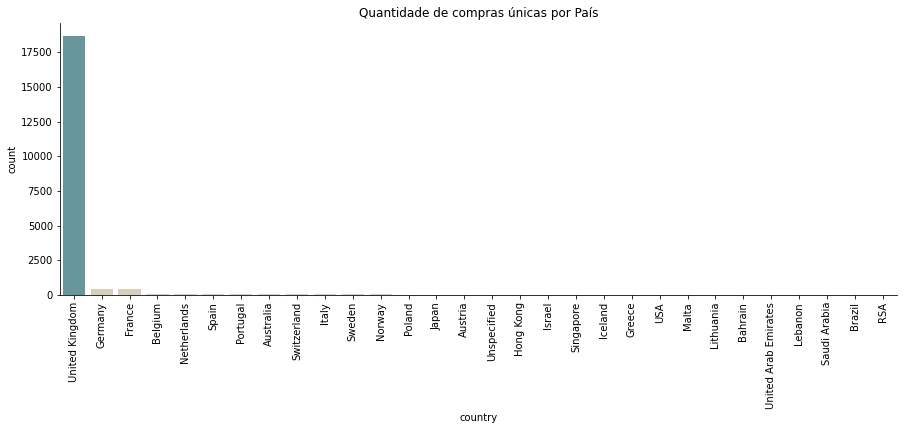

In [44]:
# agrupando dados
aux1 = data[['bill_no', 'country']].groupby(['bill_no', 'country']).count().reset_index()
order = aux1['country'].value_counts().sort_values(ascending=False)

# plotando figura
plt.figure(figsize=(15, 5))
color = set_color(order, [1])
sns.countplot(x='country', data=aux1, order=order.index, palette=color)
sns.despine(right=True)
plt.xticks(rotation=90)
plt.title('Quantidade de compras únicas por País');

### H2. Os clientes que gastam mais ficam na Espanha.

**FALSA** Os clientes que gastam mais ficam no Reino Unido.

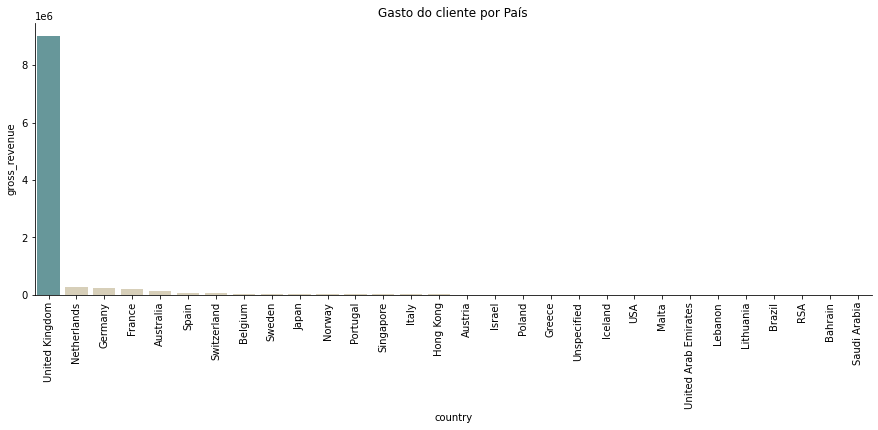

In [50]:
# agrupando dados
aux2 = purchases[['gross_revenue', 'country']].groupby('country').sum().reset_index().sort_values(by='gross_revenue', ascending=False)

# plotando figura
plt.figure(figsize=(15, 5))
color = set_color(aux2['country'], [1])
sns.barplot(x='country', y='gross_revenue', data=aux2, palette=color)
sns.despine(right=True)
plt.xticks(rotation=90)
plt.title('Gasto do cliente por País');

### H3. Os clientes que levam a maior quantidade de produtos no carrinho ficam no Japão.

**FALSA** Os clientes que levam a maior quantidade de produtos no carrinho ficam no Reino Unido.

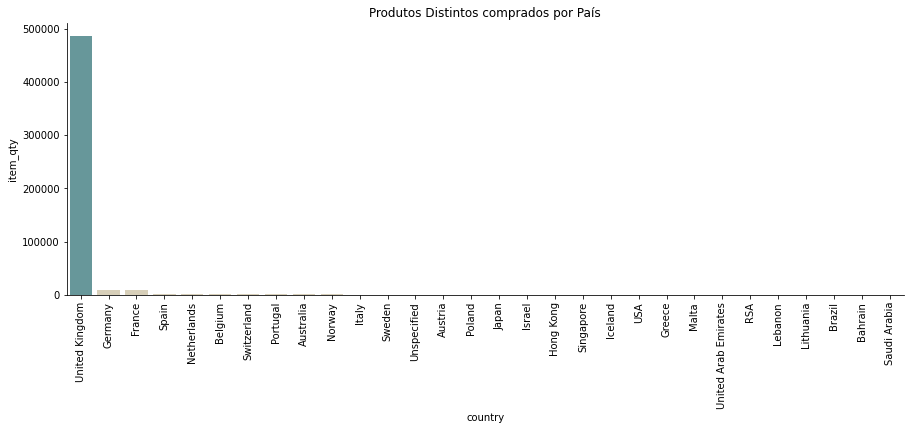

In [71]:
# agrupando dados
aux3 = data[['itemname', 'country']].groupby(['country']).count().reset_index().rename(columns={'itemname': 'item_qty'}).sort_values(by='item_qty', ascending=False)

# plotando figura
plt.figure(figsize=(15, 5))
sns.barplot(x='country', y='item_qty', data=aux3, palette=color)
plt.title('Produtos Distintos comprados por País')
sns.despine(right=True)
plt.xticks(rotation=90);

### H4. Os clientes que levam a maior quantidade de itens no carrinho ficam na Alemanha.

**FALSA** Os clientes que levam a maior quantidade de itens no carrinho ficam no Reino Unido.

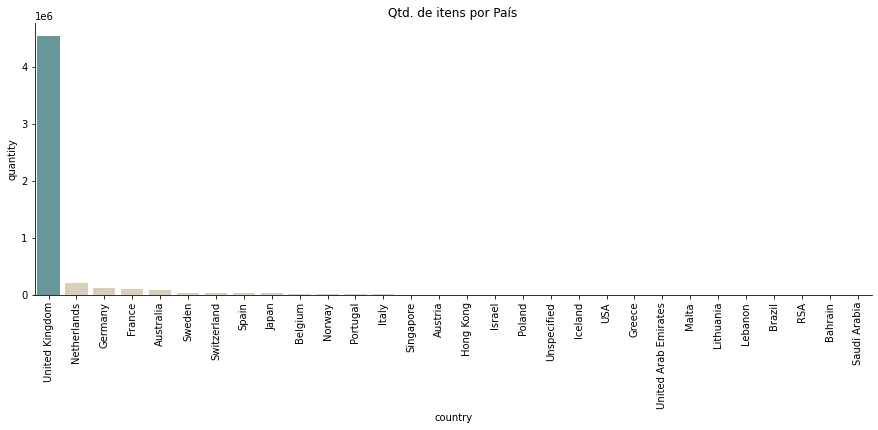

In [53]:
# agrupando dados
aux4 = data[['quantity', 'country']].groupby('country').sum().reset_index().sort_values(by='quantity', ascending=False)

# plotando figura
plt.figure(figsize=(15, 5))
sns.barplot(x='country', y='quantity', data=aux4, palette=color)
plt.title('Qtd. de itens por País')
sns.despine(right=True)
plt.xticks(rotation=90);

### H5. Clientes do Reino Unido possuem o maior Ticket Médio.

**FALSA** Clientes da Holanda possuem o maior Ticket Médio.

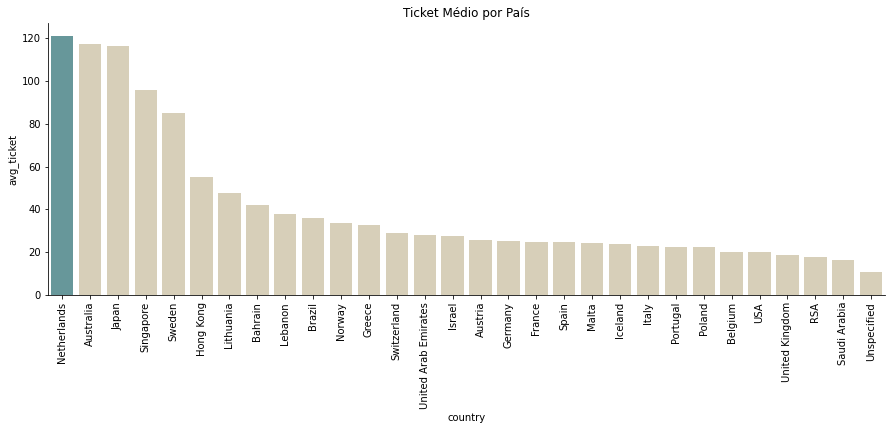

In [55]:
# plotando figura
plt.figure(figsize=(15, 5))
sns.barplot(x='country', y='avg_ticket', data=avg_ticket_country, palette=color)
sns.despine(right=True)
plt.title('Ticket Médio por País')
plt.xticks(rotation=90);

### H6. Produtos relacionados a postagem/Amazon possuem o maior Ticket Médio.

**FALSA** Produtos sobre artesanato/decoração possuem o maior Ticket Médio.

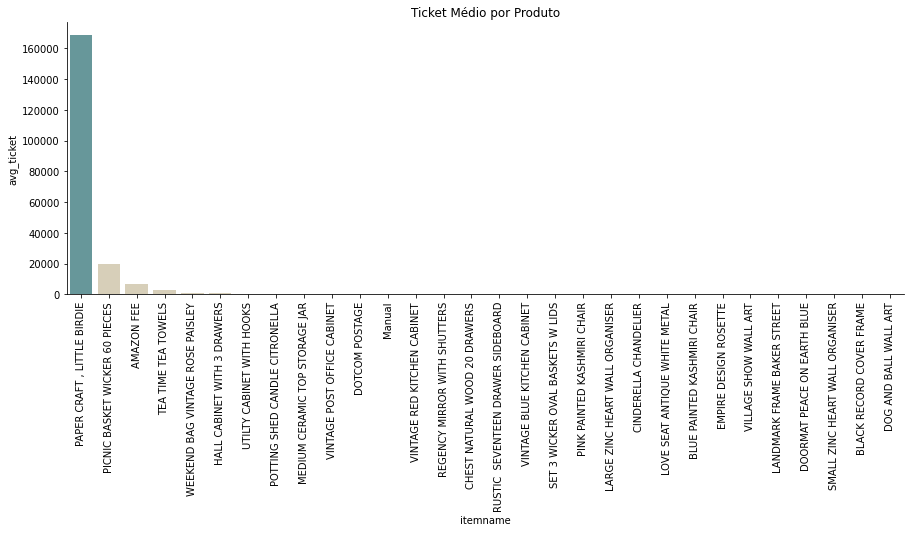

In [57]:
# plotando figura
plt.figure(figsize=(15, 5))
sns.barplot(x='itemname', y='avg_ticket', data=avg_ticket_product[:30], palette=color)
plt.title('Ticket Médio por Produto')
sns.despine(right=True)
plt.xticks(rotation=90);

### H7. Clientes da frança possuem a maior recencia de compra.

**FALSA** Clientes da Lithuania possuem a maior recencia de compra com mais de 350 dias.

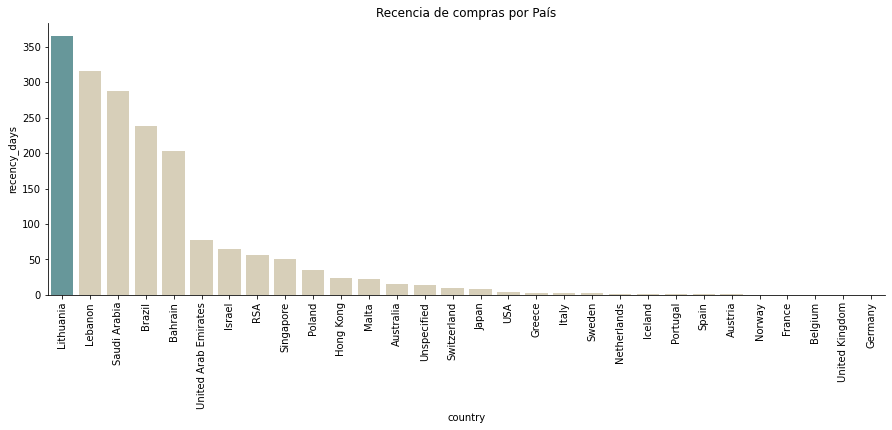

In [59]:
# plotando figura
plt.figure(figsize=(15, 5))
sns.barplot(x='country', y='recency_days', data=df_recency.sort_values(by='recency_days', ascending=False), palette=color)
sns.despine(right=True)
plt.title('Recencia de compras por País')
plt.xticks(rotation=90);

### H8. Os clientes do Reino Unido compram os produtos mais caros.

**FALSA** Os clientes de Singapura compram os produtos mais caros, em média.

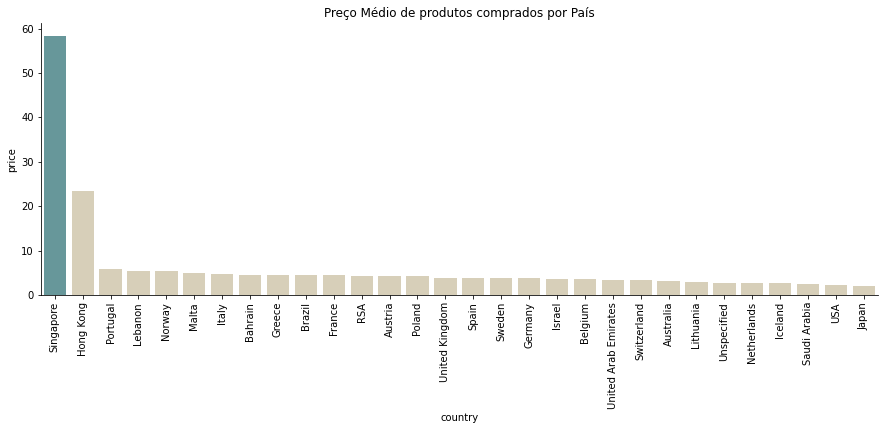

In [61]:
# agrupando dados
price_by_country = purchases[['country', 'price']].groupby('country').mean().reset_index().sort_values(by='price', ascending=False)

# plotando figura
plt.figure(figsize=(15, 5))
sns.barplot(x='country', y='price', data=price_by_country, palette=color)
plt.title('Preço Médio de produtos comprados por País')
sns.despine(right=True)
plt.xticks(rotation=90);

## 4.3 Análise Multivariada

### 4.3.1 Variaveis Numéricas

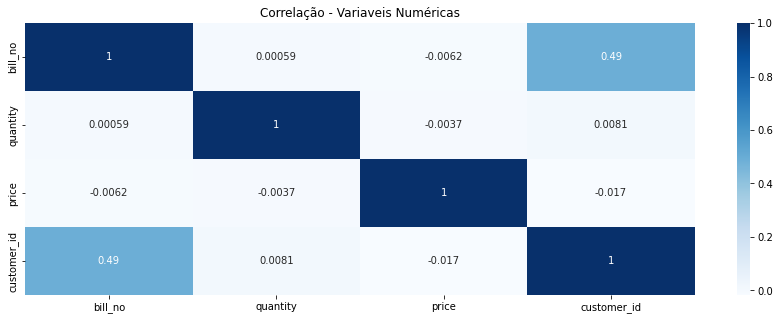

In [63]:
# plotando correlação de variaveis numericas
plt.figure(figsize=(15, 5))
sns.heatmap(data.corr(method='pearson'), annot=True, cmap='Blues')
plt.title('Correlação - Variaveis Numéricas');

**INSIGHT:**

Não há muita correlação para ser observada nas variaveis numéricas.

### 4.3.2 Variaveis Categóricas

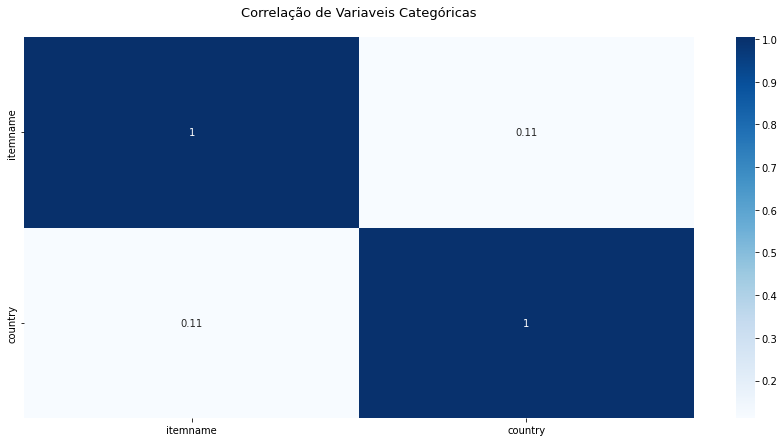

In [70]:
# filtrando dados categoricos
categorical = purchases.select_dtypes(include=['object'])

# aplicando correlação em variaveis categoricas
matrix = show_matrix(data=categorical, col='itemname', output='dict')
data_columns = categorical.iloc[:, 1:]

for c in data_columns.columns:
    matrix[c] = show_matrix(data=categorical, col=c, output='list')

# plotando heatmap
plt.figure(figsize=(15, 7))
sns.heatmap(matrix, annot=True, cmap='Blues')
plt.title('Correlação de Variaveis Categóricas\n', fontsize=13);

**INSIGHT:**

O país possui correlação fraca com o item comprado.

# 5.0  RESULTADOS

**Clientes que fazem mais compras:**
- Reino unido
- Alemanha
- França.

**Produtos que os clientes mais compram:**
- white hanging heart t-light holder
- jumbo bag red retrospot
- regency cakestand 3 tier
- party bunting
- lunch bag red retrospot

**Clientes que trazem maior retorno financeiro:**
- Reino Unido
- Holanda
- Alemanha

**Clientes que compram maior quantidade de itens no carrinho:**
- Reino Unido
- Holanda
- Alemanha

**Clientes que compram a maior quantidade de produtos distintos:**
- Reino Unido
- Alemanha
- França

**Época do ano em que os clientes mais compram:**
- Final do ano.

**Clientes que compram com menor recencia:**
- Aleamnha
- Reino Unido
- Bélgica

**Países com maior Ticket Médio:**
- Holanda
- Australia
- Japão